# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
from DYNASMART_Process import *
import DYNASMART_Process as dy
import AV_functions as av
from gurobipy import *
import datetime
import requests

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
# personData=pd.read_csv('input/personData_1.csv')
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
#Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

In [3]:
traveler_trips.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time'],
      dtype='object')

### Basic Statistics

In [4]:
traveler_trips.head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,driver_passenger_flag,joint_trip_flag,park&ride_flag,starttimeinterval,starttime,hh_id,origin_node,destination_node,Diff_bet_starttime,travel_time
0,8600957,11,0.1164,1,24.0,1,Home,Shop,1,1,...,1,0,0,1,1.0,2744264,9737,10716,30.0,6.0
1,8600957,11,0.1164,2,32.0,3,Shop,eatingout,62,16,...,1,0,0,1,31.0,2744264,10716,10057,37.0,5.0
2,8600957,11,0.1164,3,39.0,1,eatingout,Maintenance,20,5,...,1,0,0,1,68.0,2744264,10021,9674,41.0,2.0
3,8600957,11,0.1164,4,198.0,3,Maintenance,Home,3,1,...,1,0,0,1,109.0,2744264,9737,9675,199.0,1.0
4,8600957,11,0.1164,5,191.0,1,Home,work,1,1,...,1,0,0,8,308.0,2744264,9673,9736,192.0,1.0


In [5]:
traveler_trips.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time'],
      dtype='object')

In [6]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

Number of household: 	 32472
Number of traveler: 	 76499
Number of trips: 	 382158
Number of indiv trip: 	 333264
Number of joint trip: 	 48894


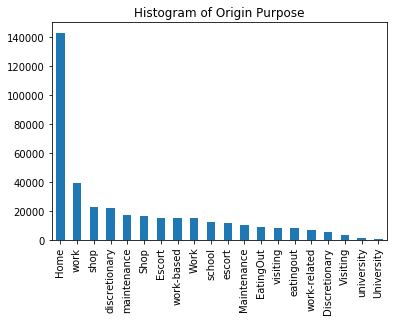

In [7]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

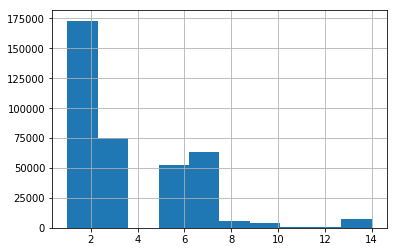

In [8]:
traveler_trips.tripmode.hist()

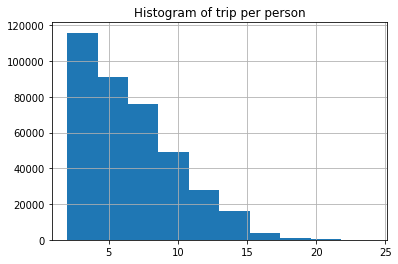

In [9]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

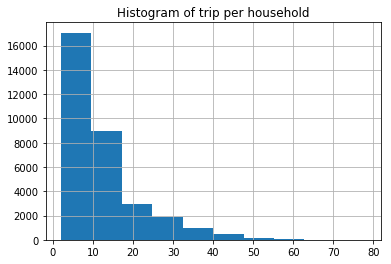

In [10]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

In [11]:
def identify_indiv_trip_before_jointtrip(traveler_trips):
    before_joint_trip=pd.DataFrame()
    for traveler in traveler_trips.person_id.unique():
#         print(traveler,len(traveler_trips[traveler_trips.person_id==traveler])-1)
        for index in range(len(traveler_trips[traveler_trips.person_id==traveler])-1):
#             if(traveler==5982639):
#                 print(traveler,index,(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0),(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1)) 
            if (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0) & (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1):  
#                 print(traveler,index)
                before_joint_trip=before_joint_trip.append(traveler_trips[traveler_trips.person_id==traveler].iloc[index])
    check_joint_trip=traveler_trips.loc[(traveler_trips['joint_trip_flag']==1) & (traveler_trips.trip_counter>2)]
    
#     if (len(check_joint_trip)/2 != len(before_joint_trip)):
#         print(traveler_trips.hh_id.unique(),len(check_joint_trip)/2, len(before_joint_trip))
    return before_joint_trip

In [12]:
# num_ind_trip=[]
# for hh in traveler_trips.hh_id.unique():
#     target_hh=traveler_trips[traveler_trips.hh_id==hh]
#     num_ind_trip.extend([len(identify_indiv_trip_before_jointtrip(target_hh))])

### Draw the sub-area network

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

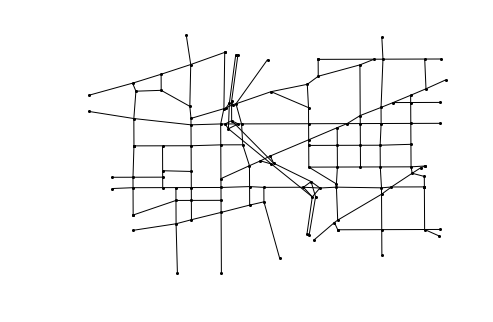

In [13]:
cluster_highlight([])

### Sample Household
Select household 2105189 for intial analysis

10


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

9
4
7


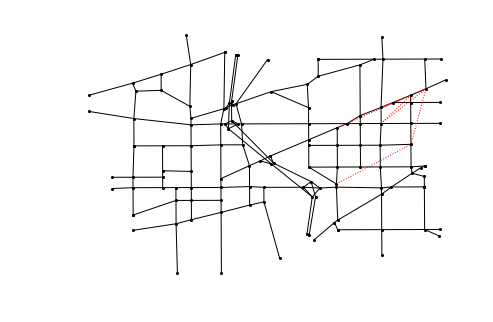

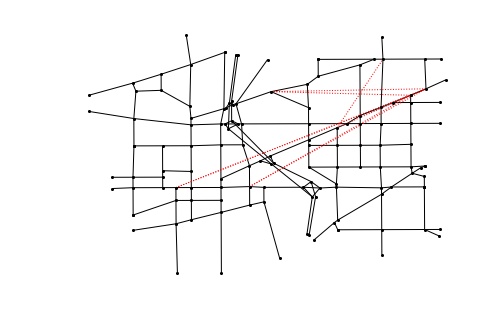

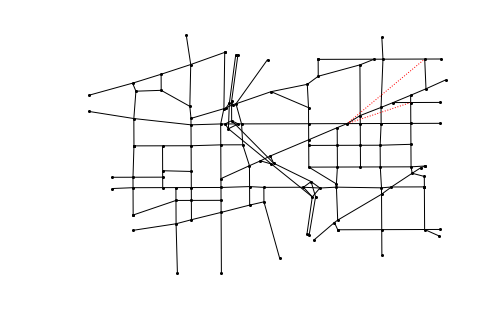

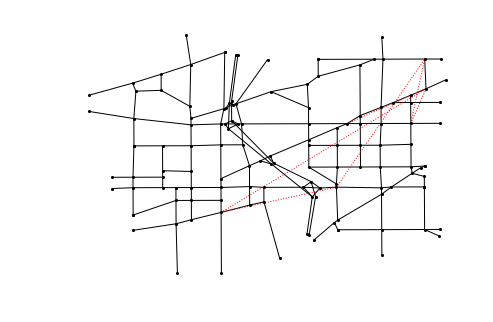

In [14]:
target_hh_id=2105189
people_in_hh=traveler_trips[traveler_trips['hh_id']==2105189]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

In [15]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

In [16]:
# target_hh_id=2105189
# hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
# # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
# num_hh_member=hh_members.size

# target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# sorted_trips=target_hh.sort_values("starttime")
# hh_num_trips=sorted_trips.shape[0]
# sorted_trips["hh_index"]=(range(hh_num_trips))
# R=np.ones(hh_num_trips+1)*15
# #Calculate the distance matrix between all node pairs
# np.random.seed(1)
# C=np.random.rand(2*hh_num_trips+2,2*hh_num_trips+2)*10
# visit_candidate=[sorted_trips['origin_node'].iloc[0]]
# visit_candidate.extend(sorted_trips['origin_node'].tolist())
# visit_candidate.extend(sorted_trips['destination_node'].tolist())
# visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
# # C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)
# c=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)

#### Solve with heuristic

In [17]:
# #Solve with heuristic
# ############################
# #Construct initial feasible solution
# def initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate):
#     #First start with the earlist trip and add the next trip whenever possible
#     #########################
#     #Sort all household trips by time
#     trip_list=[]
#     last_start_time=0
#     last_dest_index=0
#     last_travel_time=0 #The travel time between the OD of same trip
#     trip_list=[]
#     index=0
#     for index1,trip in sorted_trips.iterrows():
#         #If it does not violate the time constraint then add the trip to the route
#         current_travel_time=C[last_dest_index,index+1] #The travel time between the orig of #current trip and the dest of last trip
#         print(trip['starttime'],'\t',index+1,'\t',last_dest_index,'\t',last_travel_time,'\t',last_start_time,'\t',current_travel_time)
#         if trip['starttime']>last_travel_time+last_start_time+current_travel_time:
#             trip_list.extend([trip['hh_index']])
#             last_start_time=trip['starttime']
#             last_dest_index=index+1+hh_num_trips
#             last_travel_time=C[index+1,index+1+hh_num_trips]
#             print(last_dest_index,index+1,trip['hh_index'])
#         index+=1
#     return trip_list

In [18]:
# i=0
# num_optimization=0
# num_conflict_trips={}
# last_time=datetime.datetime.now()
# for target_hh_id in [2105189]: #traveler_trips['hh_id'].unique():
# #     hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
#     # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
#     num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
#     target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
#     sorted_trips=target_hh.sort_values("starttime")
#     hh_num_trips=sorted_trips.shape[0]
#     sorted_trips["hh_index"]=(range(hh_num_trips))
#     C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
#     visit_candidate=[sorted_trips['origin_node'].iloc[0]]
#     visit_candidate.extend(sorted_trips['origin_node'].tolist())
#     visit_candidate.extend(sorted_trips['destination_node'].tolist())
#     visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
#     C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
# #     C=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)
#     route=initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate)
#     i=i+1
#     if len(route)!=hh_num_trips:
#         num_optimization=num_optimization+1
#         if (hh_num_trips-len(route)) in num_conflict_trips:
#             num_conflict_trips[hh_num_trips-len(route)]=num_conflict_trips[hh_num_trips-len(route)]+1
#         else:
#             num_conflict_trips[hh_num_trips-len(route)]=1
#     if (i%1000==0):
#         print(i,target_hh_id,num_optimization,datetime.datetime.now()-last_time)
# #         last_time=datetime.datetime.now()

## Extract the distance information with Google API

In [19]:
# #Derive the travel time matrix from google api
# origin_node=[]
# destination_node=[]
# travel_time=[]
# k=0
# for i in nodexy:
#     print(k)
#     k=k+1
#     for j in nodexy:
#         origin_node.extend([i])
#         destination_node.extend([j])
#         travel_time.extend([travel_time_between_nodes(int(i),int(j),nodexy)])

## Solve the optimization with Gurobi

In [352]:
def extract_hh_information(target_hh_id,traveler_trips):
    '''
    Get the household related information. Those information will be used as input
    for the optimization model
    '''
    num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
    target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
    #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
    sorted_trips=target_hh.sort_values("starttime")
    hh_num_trips=sorted_trips.shape[0]
    #hh_index give an index to all trips within the household for tracking purpose
    sorted_trips["hh_index"]=(range(hh_num_trips))
    #Then only keep the 
#     sorted_trips=sorted_trips.drop_duplicates(['orig_purpose','dest_purpose','orig_maz','dest_maz','starttime'],keep='first')
    C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate=[sorted_trips['origin_node'].iloc[0]]
    visit_candidate.extend(sorted_trips['origin_node'].tolist())
    visit_candidate.extend(sorted_trips['destination_node'].tolist())
    visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
    C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
    for i in range(hh_num_trips): 
        C[i+1,i+hh_num_trips+1]=sorted_trips['travel_time'].iloc[i]
    
    visit_candidate_zone=[sorted_trips['orig_taz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_taz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_taz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_taz'].iloc[0]])
    
    expected_arrival_time=np.ones(2*hh_num_trips+2)
    expected_arrival_time[0]=traveler_trips[traveler_trips['hh_id']==target_hh_id]['starttime'].min()-1
    expected_arrival_time[1:hh_num_trips+1]=sorted_trips.starttime
    expected_leave_time=np.ones(2*hh_num_trips+2)
    expected_leave_time[0:hh_num_trips+1]=expected_arrival_time[0:hh_num_trips+1]
    
    for i in range(1+hh_num_trips,2*hh_num_trips+1):
        expected_arrival_time[i]=expected_arrival_time[i-hh_num_trips]+C[i-hh_num_trips,i]
        expected_leave_time[i]=expected_arrival_time[i-hh_num_trips+1]
        #         print(i,i-hh_num_trips,hh_num_trips,expected_arrival_time[i-hh_num_trips],expected_arrival_time[i],C[i-hh_num_trips,i])
    
    expected_arrival_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips]=1440
    early_penalty=100*np.ones(2*hh_num_trips+2)
    late_penalty=100*np.ones(2*hh_num_trips+2)
    return num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone

def dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,output_flag):
    m1=Model("AVSchedule")
    x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
    T=m1.addVars(2*hh_num_trips+2,name="T") #T represent the expected arrivial time at a node
    S=m1.addVars(2*hh_num_trips+2,name="S")
    R=np.ones(hh_num_trips+1)*150
    # B=traveler_trips[traveler_trips['hh_id']==household]['starttime'].max()-traveler_trips[traveler_trips['hh_id']==household]['starttime'].min()
    B=1440
    #Add constraints
    ###################################
    #Basic deliver and pickup constraints
    # m1.addConstrs((x[0,i]==1 for i in range(1,2)),"adf")
    m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
    m1.addConstrs((x.sum('*',i)==1 for i in [2*hh_num_trips+1]),"ToDepot3") 
    m1.addConstrs((x.sum(i,"*")==x.sum("*",i+hh_num_trips) for i in range(1,hh_num_trips+1)),"DemandbeDelivered11")
    m1.addConstrs((x.sum(i,"*")<=1 for i in range(2*hh_num_trips+1)),"PickupOnce12")
    m1.addConstrs((x.sum("*",j)<=1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")
    m1.addConstrs((x.sum("*",i)==x.sum(i,"*") for i in range(1,2*hh_num_trips+1)),"FlowConvervative14")
    m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)),"NoSamePointCircleVisit")
    # ###################################
    #Time constratins
    # m1.addConstrs((T[i]==expected_arrival_time[i] for i in range(2*hh_num_trips+2)),'ExactStartTime')
    m1.addConstrs((T[j]-T[i]-B*x[i,j]>=C[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
    m1.addConstrs((T[i+hh_num_trips]-T[i]-B*x.sum(i,"*")>=(C[i,i+hh_num_trips]-B) for i in range(1,hh_num_trips+1)),"deliverafterpickup16")

    # ####################################
    # #Late/Early Arrival penalty
    m1.addConstrs((S[i]>=early_penalty[i]*(expected_arrival_time[i]-T[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    m1.addConstrs((S[i]>=late_penalty[i]*(T[i]-expected_arrival_time[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    # ####################################
    # Special Constraints for this problem
    m1.addConstrs(x[i,j]==0 for i in range(1,hh_num_trips+1)
                            for j in range(1,hh_num_trips+1)
                            if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id'])
    
    m1.addConstrs(x[i,j]==0 for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2) if expected_arrival_time[j]-expected_arrival_time[i]<-30)
    obj1=sum(x.sum(i,'*')*R[i] for i in range(hh_num_trips+1))
    obj2=S.sum()
    obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
    m1.setObjective(obj1-obj2-obj3, GRB.MAXIMIZE)
    # m1.setObjective(obj1-obj3,GRB.MAXIMIZE)
    m1.setParam(GRB.Param.OutputFlag,output_flag)
    m1.optimize()
    return m1,x,T
def break_route_to_seg(route_info,superzone_map):
    '''
    This function break the route of an av into segements for DYNASMART depends on the travelers. 
    The function is called by extract_route_from_model_solution
    '''
    seg_index=[0]
    seg_temp=0
    i=1
    intrasuperzone_flag=[0]*len(route_info)
    for index, row in route_info[1:].iterrows():    
        if(row.orig_zone==row.dest_zone or check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map)):
            seg_temp=seg_temp+1

        elif((row.person_id != route_info.iloc[i-1].person_id) 
           or (route_info.iloc[i-1].orig_zone==route_info.iloc[i-1].dest_zone)
            or (check_intrasuperzone(route_info.iloc[i-1].orig_zone,route_info.iloc[i-1].dest_zone,superzone_map))):
            seg_temp=seg_temp+1
        if(check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map) and row.orig_zone!=row.dest_zone ):
            intrasuperzone_flag[i]=1
        seg_index.extend([seg_temp])
        i=i+1
    route_info['seg_index']=seg_index
    route_info['intrasuperzone_flag']=intrasuperzone_flag
    route_info['veh_seg_index']=route_info[['hh_id','seg_index']].apply(lambda x: veh_seg_index_creator(x), axis=1)
    return route_info
def check_intrasuperzone(orig_taz,dest_taz,superzone_map):
    '''
    This fucntion check if the trip between orig_taz and dest_taz is within the same superzone
    '''
#     print(superzone_map.loc[superzone_map.Original_Zones==orig_taz]['SuperZone'].item,superzone_map.loc[superzone_map.Original_Zones==dest_taz]['SuperZone'][0])
    return superzone_map[orig_taz]==superzone_map[dest_taz]
    
def veh_seg_index_creator(x):
    return str(int(x[0]))+'_'+str(int(x[1]))

def extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time):
    #Check the feasibility of the answer
    #route_dic store the optimiztion model solution as a dictionary. The keys are the upstream node index and the answer is
    #the corresponding downstream node index
    hh_id=sorted_trips['hh_id'].iloc[0]
    potential_next_node=set(range(1,2*hh_num_trips+1))
    route_node=[0]
    travelers=[]
    vot=[]
    activity_time=[]
    start_time=[]
    origin_arrival_time=[]
    dest_arrival_time=[]
    orig_node=[]
    dest_node=[]
    while potential_next_node != set():
        for node in potential_next_node: 
            if x[route_node[-1],node].x>0.91:
                if (route_node[-1]==0):
                    traveler_set=set()
                elif (route_node[-1]<=hh_num_trips):
#                     print(traveler_set,sorted_trips.iloc[route_node[-1]-1]['person_id'])
                    traveler_set.add(sorted_trips.iloc[route_node[-1]-1]['person_id'])
                else:
                    traveler_set.remove(sorted_trips.iloc[route_node[-1]-1-hh_num_trips]['person_id'])
                if traveler_set==set():
                    travelers.extend([0])
                    vot.extend([0])
                    activity_time.extend([0])
                else: 
                    travelers.extend([list(traveler_set)[0]])
                    vot.extend([sorted_trips[sorted_trips.person_id==travelers[-1]]['value_of_time'].iloc[0]])
                    activity_time.extend([max(0,expected_leave_time[node]-expected_arrival_time[node])])
#                     vot.extend([sorted_trips.iloc[route_node[-1]-1]['value_of_time']])
                start_time.extend([expected_leave_time[route_node[-1]]])
                origin_arrival_time.extend([T[route_node[-1]].x])
                dest_arrival_time.extend([T[node].x])
                orig_node.extend([sorted_trips])
                route_node.extend([node])
                break
        if route_node[-1] in potential_next_node:
            potential_next_node.remove(route_node[-1])
        else:
            potential_next_node=set()
            
    route=[visit_candidate_zone[x] for x in route_node]
    route_info=pd.DataFrame({'orig_zone':route[1:-1],'dest_zone':route[2:],'person_id':travelers[1:],
                             'orig_node_index':route_node[1:-1],'dest_node_index':route_node[2:],
                             'origin_arrival_time':origin_arrival_time[1:],'dest_arrival_time':dest_arrival_time[1:],
                             'value_of_time':vot[1:],'start_time':start_time[1:],'Activity_Time':activity_time[1:],
                             'hh_id':np.ones(len(route[1:-1]))*hh_id},
                            columns=['orig_zone','dest_zone','orig_node_index','dest_node_index',
                                     'person_id','origin_arrival_time','dest_arrival_time','value_of_time','start_time','Activity_Time','hh_id'])
    route_info=route_info.loc[((route_info.orig_node_index-route_info.dest_node_index!=hh_num_trips-1) | (route_info.orig_zone!=route_info.dest_zone)) ]
    route_info=break_route_to_seg(route_info,superzone_map)
    
    return route_info
def find_av_schedule_exact_method(target_hh_id,traveler_trips,output_flag):
    num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips)
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,output_flag)
    route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    return route_info

def get_route_info_allhh(traveler_trips,output_flag):
    '''
    This function loops over all the household and find the optimal path for all of them. Return route_infos that 
    stores all the route related information for all households
    
    '''
    counter=0
    route_infos=pd.DataFrame()
    row_number=0
    for household_id in traveler_trips.hh_id.unique():
        print(household_id,row_number)
        row_number=row_number+len(traveler_trips[traveler_trips.hh_id==household_id])
        if counter%100==0: 
            print('Estimate Route for the ',counter,'th household ',datetime.datetime.now())
        counter=counter+1
        if len(traveler_trips[traveler_trips.hh_id==household_id])<30:
            route_info=find_av_schedule_exact_method(household_id,traveler_trips,output_flag)
            route_infos=route_infos.append(route_info)
    return  route_infos

In [21]:
output_flag=0
target_hh_id=1839920
num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips)
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,output_flag)
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)

In [261]:
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)

In [43]:
def read_link_travel_time(link_travel_time_filepath):
    i=0
    with open(link_travel_time_filepath) as f:
        for line in f:
            i=i+1
            print(i,len(line),line,line==' ')
            if i ==6:
                z=line
    return z
def read_turn_penalty(turn_penalty_filepath):
    with open(turn_penalty_filepath) as f:
        for line in f:
            print(line)
    return 

In [248]:
def read_superzone_info(superzone_filepath):
    i=0
    origin_flag=0
    super_zone_flag=0
    origin_zone=[]
    superzone=[]
    with open(superzone_filepath) as f: 
        for line in f: 
            if i==2: 
                origin_flag=1
    
            if line.split()[0]=='Mapping':
                origin_flag=0
                super_zone_flag=1
            else:
                if origin_flag==1:
                    origin_zone.extend([int(j) for j in line.split()])
                elif super_zone_flag==1:
                    superzone.extend([int(j) for j in line.split()])
            i=i+1
    superzone_info=dict(zip(origin_zone,superzone))
    return superzone_info

In [342]:
route_infos=break_route_to_seg(route_infos,superzone_map)

In [249]:
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=read_superzone_info(superzone_filepath)

In [48]:
route_infos=get_route_info_allhh(traveler_trips,0)

2744264 0
Estimate Route for the  0 th household  2017-12-09 10:03:00.662096
3427429 15
1738047 46
724452 93
971970 120
2237514 173
3376406 196
1114135 206
2285694 220
583652 262
72808 275
2571871 288
555395 296
646726 340
1589512 346
365240 373
831952 407
1490168 428
1266940 448
1113244 472
2034213 494
3416215 517
1667375 530
2101467 580
2066815 612
3118723 643
867909 659
1588612 673
1119100 687
1489787 708
1975074 735
2035732 763
1845629 791
2035779 814
2566260 838
1630237 848
763704 880
1113838 886
1489776 893
2238689 920
1669161 972
1266865 1013
3812984 1023
2983590 1025
1845506 1035
1845526 1048
2908380 1068
1737989 1081
1588493 1103
1972436 1116
1839436 1141
867843 1152
3337721 1181
3118758 1199
2175587 1226
1486880 1254
2212392 1283
1630973 1329
3863435 1348
2238865 1356
3044578 1395
3155279 1402
763675 1419
1309691 1437
241473 1458
1437211 1479
3044738 1488
1114223 1500
1972992 1510
2102108 1537
1266603 1567
1843916 1593
3430422 1609
1739288 1624
647180 1689
2105127 1704
183947

1312805 13983
1401761 14003
1845713 14020
3349622 14033
644430 14061
Estimate Route for the  600 th household  2017-12-09 10:09:08.191127
1839967 14081
1309664 14103
2212029 14117
2212060 14150
1437235 14189
3044830 14196
2034439 14214
1786271 14232
2212078 14239
764951 14267
646871 14299
1975089 14320
1630976 14348
3118659 14379
1309567 14389
2980545 14422
1309919 14426
2175586 14447
831265 14457
2067038 14465
2980728 14501
1114529 14504
2285738 14528
1119462 14599
1489788 14607
3156939 14618
1669038 14627
1438339 14670
152788 14695
2104788 14718
3119550 14747
2101441 14754
1486367 14790
1437105 14822
1113866 14847
1588572 14868
2212356 14917
2286997 14956
1489619 14991
1630874 15037
2830777 15073
1043838 15076
1400541 15082
483968 15107
1309699 15127
1309645 15133
1265748 15146
1265810 15166
3044765 15176
1265888 15192
831885 15212
1119084 15254
2104134 15264
1043470 15292
1489804 15295
2573157 15316
1845722 15322
1113674 15353
831197 15372
2067013 15397
1114120 15428
1973008 15433
7

1400575 26231
2237500 26253
2067032 26281
644625 26310
1667665 26322
1266605 26356
2067562 26372
3156905 26389
16201 26396
2238576 26406
2105059 26440
2238911 26474
3091765 26519
1400563 26526
1486387 26532
3155448 26562
1119008 26565
1266613 26583
2287137 26598
3474669 26624
3450469 26651
152818 26661
2831307 26669
2035786 26672
2105159 26678
2066865 26714
2566793 26762
2980615 26772
1588621 26779
2104043 26795
2035595 26837
1313290 26871
869378 26901
2101397 26920
2102143 26947
1588613 26977
2921317 26997
831875 27009
1844472 27012
3044504 27033
1486215 27056
1309358 27074
Estimate Route for the  1200 th household  2017-12-09 10:14:46.624497
2101399 27086
2980263 27121
3066920 27130
1309659 27149
1437161 27162
2285678 27186
3391675 27239
2287019 27255
1438154 27273
2238718 27304
3046109 27349
1113645 27375
1972653 27401
2237526 27427
1114163 27461
72757 27470
3118841 27472
1012055 27480
1119497 27496
1844315 27509
1120080 27529
2034230 27539
583562 27553
1738151 27564
831260 27602
21

2238843 37944
2035716 37966
2238840 37983
2067739 38013
1313269 38038
1845678 38046
3440851 38073
2101362 38091
2945186 38128
916504 38134
3132920 38148
1630209 38186
483946 38218
1042030 38233
1309542 38244
1839743 38271
1309523 38277
364672 38308
1839893 38323
1309563 38343
2101696 38353
1630259 38376
1012019 38415
1486520 38457
3418754 38486
297533 38502
3091811 38523
644617 38529
1309826 38548
2825524 38571
1265884 38573
2175575 38580
3118828 38592
2285722 38599
1738159 38648
3118842 38698
2285731 38707
1310089 38748
1012063 38780
484035 38798
1042271 38836
1945087 38842
2982960 38873
1118918 38879
1266586 38894
16161 38907
1119091 38917
3045904 38924
764988 38934
3409743 38945
1669167 38977
3157178 39020
1669231 39027
1669322 39044
1589765 39087
1589778 39104
1120589 39138
1120612 39156
1739527 39165
647374 39214
3044579 39228
297503 39232
1839469 39251
3044581 39258
3044513 39268
3155339 39288
3069807 39298
1486237 39306
2237276 39337
1486239 39394
644407 39417
831173 39426
16302

1490151 49943
3857462 49982
1266929 49988
765288 49998
1669356 50005
2573624 50047
583465 50051
2101405 50062
1738029 50068
971932 50121
1839690 50150
1738038 50164
Estimate Route for the  2300 th household  2017-12-09 10:25:42.989064
3427434 50188
1113680 50223
1972672 50230
3427437 50247
1309676 50261
3812256 50269
1437206 50272
1114087 50304
2212024 50318
1840386 50366
1972856 50373
151766 50397
3224028 50405
1630298 50422
2566845 50465
1309924 50468
1630318 50480
297583 50525
3440540 50541
2176789 50562
2571992 50582
916734 50586
1119030 50608
1630841 50618
298107 50646
2238481 50660
2176947 50694
1119421 50711
2104375 50724
1438242 50754
3458825 50782
2104708 50794
1490074 50836
1313064 50873
869263 50883
1490206 50916
2573347 50928
2035589 50932
242314 50952
2067708 50978
2573355 50992
152811 50995
1401846 51001
2238832 51020
1490360 51056
1401835 51075
1630985 51088
2035778 51103
74388 51117
2105234 51124
1438452 51158
2105141 51185
1975335 51202
2238867 51218
3416214 51257
2034

1972887 61890
3427442 61898
2237510 61937
1265773 61988
2212047 62005
3044725 62053
2744284 62067
2566913 62086
2567107 62096
3044843 62101
1840540 62108
583630 62112
1114295 62119
2825908 62126
1486867 62129
644746 62159
2237602 62165
2285750 62210
409311 62226
972118 62254
2035352 62304
1266594 62329
152588 62343
2104172 62347
2035403 62357
2104363 62369
2287149 62386
1489744 62402
2104456 62418
3046038 62442
831953 62451
2983490 62480
298256 62490
2212517 62514
2212548 62556
337657 62598
1313301 62618
1845651 62630
1972448 62649
483949 62679
2211926 62731
2825140 62763
1309576 62768
1113641 62777
2388900 62782
644556 62787
2212030 62798
1114176 62838
2237558 62853
1588599 62892
Estimate Route for the  2900 th household  2017-12-09 10:31:28.378833
1309917 62928
2175596 62956
2175633 62988
1843969 62994
2104421 63006
2983569 63030
2287427 63038
2287448 63091
1401827 63116
2067776 63130
3832427 63166
3118660 63171
1041990 63185
1786033 63196
483934 63203
2101425 63246
2066785 63279
166

1738026 72417
1588508 72442
1839641 72457
72571 72467
1972451 72476
1113532 72486
3427436 72497
644514 72504
2101719 72512
1486674 72523
1840392 72536
3464983 72553
2285689 72568
1630300 72610
1738139 72662
2102023 72681
644604 72711
1667600 72717
1972976 72771
724493 72787
1972964 72820
2825624 72831
1437252 72840
1310066 72856
2825868 72884
2175621 72888
409288 72905
1043375 72940
3577434 72947
1945088 72950
1118943 72978
1786880 72992
1843985 73011
3045834 73017
1844071 73032
1119047 73045
2176950 73057
2104384 73069
2287163 73089
3409709 73120
1119554 73140
2212429 73148
2176989 73175
3376775 73196
725206 73207
1120066 73223
1975022 73233
1845010 73252
869278 73258
2104745 73275
2238712 73301
3467879 73339
1844999 73351
1845536 73359
3069913 73368
1669345 73399
1845727 73439
2573671 73450
2105155 73453
1738000 73483
1309344 73500
1839438 73509
297482 73517
1839549 73531
1113349 73539
1486223 73559
1839638 73597
1486281 73602
1588499 73624
1309537 73654
1972503 73683
2101536 73699
2

1486540 82583
1840085 82612
3416223 82619
72638 82631
2101707 82636
2825263 82667
1437156 82669
2285647 82697
2067011 82713
1840452 82733
1667604 82741
2825646 82786
1437244 82794
1114273 82816
2067045 82830
3261125 82844
2175613 82857
3127959 82881
972794 82897
3391666 82934
Estimate Route for the  4000 th household  2017-12-09 10:42:09.542493
3469940 82940
2287035 82951
365243 82962
1739281 82977
2035558 82997
1975060 83027
3376841 83053
1589673 83061
647177 83080
2831004 83086
337650 83090
3461938 83096
2035719 83112
2177246 83145
2067775 83168
1845708 83184
2105167 83202
2238872 83232
2980155 83254
1839519 83258
3427416 83274
644352 83284
1042006 83289
3401922 83299
2034252 83310
3427433 83334
2175378 83362
1486461 83390
2211958 83417
1840026 83453
583549 83464
1113835 83466
972013 83486
1113884 83500
2175482 83514
867902 83547
1588580 83572
1309857 83598
2566814 83612
3044854 83620
1114300 83631
2567152 83656
2566907 83662
2920770 83666
1486832 83672
1114505 83698
1400658 83712
28

2829897 92347
1401638 92354
2212366 92364
831883 92400
1119058 92415
1630873 92429
1489746 92461
3156947 92484
1974813 92487
2212494 92500
1589665 92533
1739392 92548
831957 92560
409867 92591
3157163 92603
1012517 92613
2831037 92661
2104741 92665
1845008 92697
1945268 92719
1845037 92744
3578945 92752
1490162 92758
1975267 92783
1787180 92814
2177258 92818
1313313 92833
2831334 92844
1120623 92848
1588477 92863
1839459 92884
644366 92897
1113221 92906
3044555 92915
1839446 92932
3344203 92941
2566291 92962
1113385 92965
1839741 92984
1437112 93009
72583 93022
2211972 93029
937962 93068
2237377 93083
1309673 93110
3307945 93122
2566574 93127
2237389 93134
1113917 93167
2237519 93187
3409465 93227
3440512 93242
3573081 93254
2237548 93257
1042171 93294
1786240 93306
1667605 93318
1972942 93355
Estimate Route for the  4600 th household  2017-12-09 10:48:09.365089
3044736 93378
2567131 93388
1738153 93391
3155622 93425
2102122 93439
409308 93452
2102155 93469
867944 93484
3577442 93515
1

2035738 102056
2177243 102076
1739512 102098
647322 102149
2105147 102158
1630988 102189
2831315 102217
1839512 102222
555242 102247
2566199 102266
2980193 102273
2920662 102279
1113351 102290
1972461 102301
2285455 102324
937951 102369
867809 102386
3127930 102418
1113339 102437
3044597 102452
2237252 102463
2066781 102502
2980252 102516
2101412 102525
1839697 102550
1012008 102560
1786050 102617
3409448 102627
2825170 102637
1839906 102644
2825162 102655
3281392 102659
867851 102664
2034269 102685
1309568 102696
1738069 102707
867849 102750
241433 102758
1400584 102771
1972688 102785
1113766 102796
763700 102805
1486503 102820
1113886 102839
2175410 102856
3044671 102875
1840402 102884
1486670 102890
1114031 102917
2067003 102927
1840480 102949
644614 102958
811472 102967
555274 102977
3779305 102985
1309914 102992
2175578 103002
2566962 103013
1114266 103023
1437240 103034
2567104 103073
1265825 103078
2920730 103096
2825703 103104
1840670 103107
1309979 103117
1486814 103130
763777

241444 110493
2101710 110505
1786146 110531
1265775 110535
2566705 110546
1265786 110551
644550 110567
3472040 110577
1972870 110627
297558 110639
1309778 110667
2066993 110678
3427446 110700
2034391 110714
2237550 110724
2566858 110763
1840595 110765
3118821 110771
2102078 110776
1667614 110797
1114360 110826
1309977 110852
972070 110865
2825594 110878
1114301 110884
1042216 110892
2825649 110905
1944734 110913
1667625 110932
2102117 110941
1309980 110971
2825838 110981
241498 110987
1486828 110997
2034470 111010
972077 111021
3091879 111052
2102103 111056
1486932 111080
937988 111095
1437303 111132
3344222 111142
1310074 111156
2571877 111180
1843928 111182
938467 111186
3577665 111228
3465011 111236
2176804 111249
2287010 111266
2983061 111301
1438153 111310
2287043 111334
1844027 111363
2176823 111371
2035485 111408
1589543 111419
1489782 111431
2035468 111446
3450433 111461
1974822 111472
3045917 111480
3359339 111485
584679 111504
764977 111513
1669054 111524
2238591 111578
21046

1312782 118402
646863 118425
584667 118431
2212443 118442
1739287 118481
2287183 118485
2238574 118505
1844861 118544
2573246 118550
2104668 118552
2983445 118573
2830766 118575
2104656 118578
1401743 118609
1844924 118621
3359396 118637
2212525 118649
1845066 118667
2177100 118676
2573320 118702
2177105 118710
1945267 118730
2573384 118747
2573376 118753
3409781 118759
2067740 118784
1120526 118808
1266925 118814
1589752 118826
2105032 118842
3247145 118868
1845498 118873
2831329 118880
2212621 118884
647343 118917
3069915 118927
1975281 118937
1669344 118965
2831291 119002
2035765 119005
1313302 119014
584930 119025
Estimate Route for the  6200 th household  2017-12-09 11:03:55.446238
1845613 119038
2980209 119051
2824963 119055
3307873 119061
2824916 119071
2175268 119076
1113406 119096
1113427 119102
1972450 119116
3401912 119126
1738016 119147
1786047 119162
72578 119176
2237320 119189
1972495 119224
2285488 119241
1113506 119256
1944649 119266
583489 119274
3091768 119278
2980261

409294 126442
3427453 126456
1266618 126466
1119007 126483
831853 126496
1945086 126506
3308490 126526
2035345 126547
1974599 126566
2104199 126578
2287009 126597
Estimate Route for the  6700 th household  2017-12-09 11:09:05.262972
831882 126613
1489639 126645
1945097 126661
1266656 126669
1786895 126675
1630842 126685
1312795 126735
1489757 126745
2287170 126765
1945172 126789
1119416 126814
2104408 126833
2104395 126851
1043501 126873
2035512 126891
2830913 126904
3157173 126906
972934 126912
1589666 126924
2573125 126936
2035584 126943
1669234 126949
1975044 126977
3430467 126990
152808 127001
1120129 127009
2573316 127019
1120519 127026
2983731 127032
2177247 127034
1787211 127045
2573650 127052
1845724 127061
1669358 127069
1845624 127083
647379 127088
1313274 127097
1401852 127112
644354 127138
1839534 127152
867806 127158
1309355 127182
1113236 127187
1486272 127199
1486228 127231
2066789 127249
3155385 127285
1113504 127301
1113501 127316
1486371 127323
1839975 127333
1113656 

1119472 134539
2572298 134548
2176984 134551
1844511 134573
1119502 134588
2983482 134594
2104782 134598
1313096 134616
2238698 134643
1438358 134680
1120185 134694
1490197 134706
1845520 134720
2035767 134732
1845647 134741
1845705 134749
1313297 134761
1975326 134769
1490415 134787
2908382 134802
1839480 134824
2920678 134829
1113272 134834
763663 134844
1309429 134851
2566272 134877
763690 134883
2825073 134906
2237273 134916
2825025 134941
1309461 134945
1309486 134957
1113518 134970
971929 134978
2175319 135004
1839928 135034
1265738 135041
971978 135063
1486528 135078
1588558 135092
1265774 135117
555270 135137
2066964 135154
2237501 135176
72681 135191
2825533 135205
2034458 135209
3044747 135221
2567123 135223
409278 135225
2908411 135254
2034463 135258
2825736 135266
1310020 135272
3069828 135285
1114462 135295
1840732 135303
241510 135311
1012068 135328
1489597 135343
242129 135358
3025608 135366
1266637 135372
1668956 135387
1489620 135408
1974595 135421
646699 135443
178689

1114517 142521
3045810 142531
2104082 142544
2104096 142581
1739242 142599
1266647 142635
1489607 142642
2830068 142659
831869 142664
3430404 142678
646859 142690
2830306 142694
1844333 142697
1844477 142715
972827 142721
1313076 142730
3414002 142748
242307 142757
2104687 142781
1120024 142809
2104702 142817
298246 142833
1669209 142845
584822 142859
152822 142868
2104756 142876
1490137 142889
1120151 142900
2983592 142907
298263 142912
3409783 142922
1401843 142929
1589781 142942
1120645 142958
3092825 142965
3282410 142971
1975325 142985
365373 142995
1490390 143008
1120679 143040
971888 143052
1309349 143080
2566085 143094
1738021 143099
2101436 143149
1786085 143179
1972514 143187
2175315 143199
2101534 143213
3155395 143239
644451 143260
644438 143275
867847 143295
1630255 143320
1309557 143335
1667494 143343
3066921 143382
1113780 143404
Estimate Route for the  7800 th household  2017-12-09 11:20:08.386176
1113922 143416
1114060 143423
1309845 143435
1114192 143442
1486744 14344

2920693 150363
644471 150371
1012013 150377
3467808 150396
72625 150429
1113791 150436
1972691 150446
1309700 150465
241445 150491
3464971 150498
151737 150510
1400610 150517
1012025 150525
2175409 150535
2237396 150544
644529 150568
3572871 150574
644557 150579
2980468 150584
2101897 150588
2101948 150599
644553 150610
831223 150618
1840406 150631
2066965 150641
2034372 150674
2101890 150691
2212045 150704
Estimate Route for the  8300 th household  2017-12-09 11:25:08.930091
972049 150720
2920714 150745
1667591 150752
2237555 150767
1042179 150803
241486 150816
2102030 150818
3044841 150830
3044834 150837
3044837 150843
1265851 150849
2825654 150859
2102089 150865
1309939 150884
3409472 150893
2567051 150920
1437243 150923
2566999 150936
2237596 150938
1486825 150974
3450299 150998
1667624 151010
297573 151035
763772 151047
644714 151058
72802 151070
3458807 151075
1840735 151095
1310064 151103
1310054 151117
151816 151132
867943 151146
1588620 151165
3155642 151177
3281994 151191
257

3155375 158313
1486347 158318
2101453 158330
1667401 158340
1786087 158387
3307904 158390
1486374 158397
1839733 158410
2101505 158421
1839699 158452
1839976 158463
1113694 158474
2211973 158478
1738088 158509
2980323 158530
971962 158533
1840010 158546
1113648 158556
2285547 158566
3572608 158586
1972686 158593
1113747 158604
1667487 158621
1113810 158635
3832440 158643
971997 158646
1400606 158655
2825309 158677
483989 158681
2237400 158700
2825425 158735
2101901 158737
2980453 158752
2980477 158757
2101949 158766
867897 158807
1114058 158827
1972850 158837
583582 158847
1738124 158851
1309819 158898
1778097 158906
1840303 158918
2825506 158924
1309847 158933
2175549 158945
1437223 158956
2067020 158993
1667584 159028
1486698 159042
2566750 159063
1972913 159068
3091817 159086
72705 159091
2175556 159108
1840501 159120
1972943 159130
2175557 159137
1309875 159160
2566967 159169
2567099 159175
3091863 159182
1786270 159187
3066929 159191
2567098 159200
3131212 159204
3025367 159226
19

2831240 165710
1120520 165717
1669328 165735
2983729 165742
2177249 165749
2177210 165763
1845535 165778
1266930 165782
1975313 165799
3580035 165808
2105131 165813
2287467 165844
2105205 165866
1490432 165882
2287466 165898
1120663 165942
2831280 165949
3450517 165951
1975289 165963
1739540 165987
1120583 166027
1113328 166039
1486210 166058
15810 166070
297477 166074
364654 166095
1667371 166112
1042003 166134
1265688 166142
3326509 166165
1011998 166177
1667366 166191
2034218 166202
1972487 166214
2237302 166228
2101531 166267
3246929 166274
2034240 166287
483957 166303
2237284 166340
1738051 166358
1839703 166380
1113460 166395
2825086 166406
1972485 166409
2066875 166431
1588551 166459
867841 166474
3376354 166485
1738083 166488
1437142 166499
202391 166512
2101660 166525
1839977 166557
1840016 166565
644496 166587
867862 166593
2388825 166604
1486502 166614
1113894 166630
3401931 166644
2566544 166649
1486570 166655
3779271 166669
1309772 166672
1840357 166679
2101922 166686
2285

3450467 173137
938522 173150
647167 173195
3247147 173211
2212589 173228
1120502 173238
647331 173247
1266918 173255
2831250 173274
74399 173277
2105132 173281
2212640 173295
1975287 173326
2177274 173332
916808 173357
2566186 173370
1839517 173374
2034180 173378
1839466 173392
1041988 173399
1667359 173411
1786039 173414
2101409 173423
644411 173438
1630216 173442
483952 173461
1113528 173493
1839744 173503
971917 173515
1486401 173533
1630250 173542
2285503 173579
644457 173632
2175301 173644
1400546 173666
1113544 173682
3440466 173688
971923 173697
1265703 173727
3326530 173743
3044631 173750
2101678 173759
Estimate Route for the  9900 th household  2017-12-09 11:41:20.542762
1667455 173774
2175373 173829
1839957 173842
2101650 173851
3779224 173866
1113628 173871
724419 173877
1738081 173890
1486462 173910
1113757 173919
3474576 173933
1486534 173941
2566629 173952
2825252 173958
241446 173960
972009 173966
1114037 174011
1840422 174019
2237491 174034
2101885 174049
1786208 174080

2175317 180183
1042020 180191
2066800 180201
1839675 180216
2285497 180231
1944644 180259
3326514 180283
3409450 180291
1486490 180299
297525 180322
1839918 180338
1667463 180348
2566467 180364
2980346 180370
Estimate Route for the  10400 th household  2017-12-09 11:46:23.625510
1113796 180376
151721 180393
1667481 180400
1113913 180417
1840059 180424
2980389 180432
2980404 180438
2101996 180443
2285639 180458
1309790 180479
1840435 180495
2175484 180499
2566710 180523
1840332 180528
1114129 180535
1042153 180548
2285682 180552
2212052 180595
3440519 180610
1840505 180631
1309893 180640
2102039 180648
1486761 180663
1309860 180692
2825525 180718
1309898 180724
1667608 180745
3044776 180762
2825663 180770
2566852 180772
1840633 180777
644680 180785
583640 180789
1114346 180803
2567080 180811
2980683 180819
1114331 180824
1972978 180835
2237569 180843
2825687 180879
2825662 180883
3850731 180888
2067067 180893
1310002 180925
763785 180940
3344224 180966
1738179 180974
1486884 181000
7400

1845095 186946
2831034 186956
725309 186964
2238706 186969
2983720 186987
1120549 186991
2105049 186998
3474711 187017
1975371 187028
2573668 187039
2035793 187043
2238906 187057
1845608 187079
3450515 187092
1975368 187104
3118664 187121
435747 187130
831165 187140
1737997 187169
2566091 187198
644373 187201
2825046 187209
3458783 187211
1486273 187216
1667379 187228
1667390 187256
1738046 187282
1113474 187297
1309446 187302
1437092 187315
3440457 187331
1309498 187338
1839720 187355
971949 187364
971954 187390
1839895 187418
831201 187445
1486466 187462
2980320 187495
2980339 187501
563607 187506
2175397 187525
1309650 187546
1486552 187555
72637 187593
1265751 187611
1042070 187622
583583 187633
3850714 187649
3401935 187653
555273 187660
2101947 187674
3044699 187703
2101995 187709
1042167 187720
1738132 187723
3066926 187758
3044720 187773
2175514 187782
151760 187810
2566759 187821
644622 187828
2566819 187836
1486777 187841
3246962 187857
2566813 187864
1972957 187870
644646 18

1113713 194091
2237357 194097
3458792 194117
1309615 194127
1113820 194138
1400599 194148
1486519 194158
1840029 194167
3416222 194174
2101709 194204
2566535 194217
2566512 194219
1309726 194226
1667569 194234
972024 194265
435765 194322
3307969 194339
2175503 194357
2285654 194375
297553 194390
1972847 194398
1486696 194408
2212058 194419
2285669 194452
644615 194481
72694 194485
2175517 194493
3464990 194518
1973006 194533
3044800 194540
1840607 194550
3091846 194557
1972968 194561
1114281 194572
2980611 194578
2980662 194580
1042205 194587
1588603 194593
1114371 194604
1944746 194611
1840688 194621
72806 194628
1486808 194634
1840652 194654
3281523 194664
3069829 194671
644734 194682
1114534 194691
2034491 194701
1489596 194716
3156765 194744
1668952 194766
1974586 194791
646692 194814
2728034 194819
2104048 194830
1630838 194858
1945107 194881
1974639 194903
972801 194918
Estimate Route for the  11500 th household  2017-12-09 11:57:39.396452
3779941 194922
3224399 194924
2176797 19

1973040 200925
1437286 200942
1437305 200964
409299 200978
1739231 200990
3119400 201017
1118970 201025
2104060 201034
1489579 201049
2983015 201062
831865 201064
831858 201075
1843878 201079
2035353 201096
1118950 201109
3376743 201122
3461899 201135
2104183 201145
3461909 201159
938487 201167
764954 201212
1489774 201225
3326754 201238
2238589 201249
3461913 201262
1669042 201276
1786980 201295
3857452 201306
2983529 201309
1313048 201311
1257290 201324
Estimate Route for the  12000 th household  2017-12-09 12:02:34.366335
3857435 201331
2177066 201335
1669179 201360
3450459 201397
2830857 201406
3450462 201410
2035560 201419
2983521 201430
2573209 201436
2390586 201439
2212531 201441
1975055 201470
584815 201483
3092760 201487
1845025 201493
3440785 201503
1490153 201519
1120166 201535
3282226 201545
1120152 201555
2831234 201560
1490358 201571
973021 201583
2035734 201604
1630984 201624
2212634 201641
2983750 201672
3326813 201674
2105158 201689
2824969 201703
2066761 201709
971900

1114308 207831
Estimate Route for the  12500 th household  2017-12-09 12:07:33.739470
1786259 207839
1114365 207849
409279 207856
724500 207870
2825593 207884
3224048 207886
72777 207898
3281494 207906
1309998 207924
1114392 207935
2980753 207939
3155610 207942
1973051 207953
1667641 207978
151814 207994
1437277 208002
1738194 208022
2825869 208032
831308 208034
3376466 208059
409305 208069
2285743 208071
72848 208091
484029 208096
1114450 208113
3155689 208122
1843860 208131
1118961 208135
1974616 208148
1043382 208169
646687 208182
1739235 208203
1043386 208230
869036 208237
152620 208243
2104119 208254
1401658 208294
2830059 208307
2238488 208312
2176794 208328
1843955 208342
1974651 208349
1844292 208360
584669 208372
1119488 208379
2176959 208393
1119457 208403
1844438 208413
3461914 208423
2035514 208453
2287182 208461
2212407 208470
1844485 208495
1589554 208502
2573262 208515
647150 208517
2830880 208523
1669183 208529
2104766 208549
647188 208566
2212529 208580
3224485 208624


1486756 214587
2825539 214595
15847 214600
1114227 214606
831251 214614
1309941 214639
2567129 214655
3118786 214659
3391337 214668
2920754 214681
2566973 214686
867920 214693
2825630 214696
1973003 214698
72752 214707
1042207 214717
1840568 214722
1486804 214730
2567056 214745
644720 214751
1486826 214756
484026 214772
1310014 214802
1486876 214824
1310092 214851
1786328 214863
2980805 214882
3376467 214886
527215 214900
2571907 214904
1312565 214916
2829883 214922
152618 214929
1118936 214946
2571910 214955
1118910 214957
2238468 214966
1974605 214994
2982966 215004
1312567 215009
831854 215017
1118986 215050
1489580 215061
2983028 215071
764899 215079
1119072 215093
1119097 215102
484549 215108
1489634 215134
435854 215163
1119041 215186
1312586 215199
3045840 215214
3376741 215224
2104116 215228
3131289 215258
1844046 215271
1119050 215285
646738 215292
3578055 215298
764946 215300
2212406 215315
1489823 215357
2104430 215385
725216 215390
1786985 215398
2067612 215411
3409713 2154

2237245 221219
555243 221232
1588485 221255
72565 221268
867791 221276
583459 221286
2744273 221299
1113389 221308
2175266 221322
1486352 221338
3779207 221346
1486388 221348
1839661 221382
1486373 221389
3472018 221414
2175298 221463
3376342 221480
3418736 221485
1972532 221509
1839672 221517
2237290 221536
2175285 221554
1486361 221574
644450 221585
1972492 221590
1972544 221606
2101472 221611
1839728 221624
1588515 221636
2980274 221644
1309572 221648
3281376 221664
1309560 221679
2566402 221693
1839904 221695
2825155 221706
3155466 221708
1113670 221719
2101665 221725
151728 221731
1486530 221745
1113758 221780
972002 221786
1113729 221794
1400590 221802
2101700 221806
1486506 221837
1012021 221859
Estimate Route for the  13600 th household  2017-12-09 12:18:32.413171
1309642 221867
1113885 221873
72639 221877
644522 221883
1486671 221891
2825382 221904
2101976 221912
2825391 221940
2101969 221945
3307970 221960
1437205 221969
1588568 221978
1437207 221985
867890 222020
2175507 222

2238599 227538
1844401 227555
1844390 227573
1844513 227582
1844417 227589
1266740 227598
1974806 227623
1489822 227633
2212420 227673
2830905 227687
3578898 227691
2287270 227693
3578656 227709
3308652 227713
1438334 227725
1844837 227742
2830805 227749
1844951 227756
2287264 227762
Estimate Route for the  14100 th household  2017-12-09 12:23:23.691959
3391771 227784
484703 227793
647169 227810
765150 227814
1975048 227825
3046063 227836
1313093 227842
3440783 227853
2573330 227871
765136 227873
1669193 227883
1043725 227899
2983580 227908
3308679 227910
3465019 227914
765149 227922
3326781 227929
811841 227936
1043722 227964
2573321 227981
647321 227983
1120497 227990
3308785 227994
2105044 228002
3092798 228036
811859 228039
1028172 228053
2105208 228057
1401856 228089
152887 228098
1490402 228113
2035797 228139
3282390 228151
1845747 228156
2105229 228161
1845715 228173
3391845 228179
2105180 228190
1787195 228207
3046101 228211
1113240 228217
1041983 228223
1113229 228231
1972431 

724522 233906
2566957 233921
2825568 233923
1042228 233925
1114378 233933
2825709 233945
3044846 233947
2388997 233957
2389027 233961
2237594 233965
1400657 233990
1840665 234005
2825858 234009
2102142 234013
2102135 234027
3118853 234041
3467827 234045
484024 234055
972097 234072
3391345 234077
1486838 234093
763786 234118
831284 234131
763789 234170
2285763 234178
73999 234228
1438142 234233
3072182 234248
2829880 234264
1668954 234266
3119401 234289
484535 234294
2104089 234327
2829956 234358
1843886 234364
1118928 234372
764886 234383
3779895 234393
2035395 234395
2067519 234407
1489626 234426
2176812 234454
869048 234474
1844015 234492
3578094 234498
1669014 234500
1312771 234530
2176957 234540
831911 234554
1489824 234572
1844464 234578
1974837 234585
3376777 234594
1844471 234602
3402029 234608
242186 234619
3780000 234628
2104446 234630
2921364 234661
725205 234670
1844923 234685
1119991 234694
584786 234704
2983534 234706
2104644 234708
1257287 234725
3430448 234734
1844856 23

3467822 240047
1265805 240059
2034407 240068
2237544 240081
1437209 240118
644619 240132
724491 240140
1738140 240157
3573154 240173
3376442 240176
1309900 240195
1486802 240211
2566859 240239
3044850 240241
2566975 240249
2566897 240251
1042214 240255
2388990 240261
3044761 240264
1437242 240271
1630311 240294
1972982 240306
3091860 240321
831279 240325
1309990 240348
1486817 240359
972081 240373
3091873 240406
3450302 240410
724547 240417
1667658 240435
241503 240447
1588616 240454
3573419 240463
1630328 240465
1486931 240497
1840756 240509
2744296 240517
152615 240523
646719 240530
242136 240541
1266604 240551
3045814 240561
1739236 240568
1589495 240575
2104079 240595
1266602 240601
1118930 240608
1843877 240617
1945093 240625
2921318 240631
484548 240636
1489599 240659
2238457 240676
1786911 240706
242154 240710
1119052 240725
2830067 240731
2571950 240735
2571998 240739
1119029 240744
2238507 240761
1844280 240795
2212395 240805
365241 240836
1489765 240865
3069899 240878
Estimat

3044833 246343
3307984 246358
409273 246368
2389040 246377
1973020 246379
1667621 246383
972075 246400
1840645 246421
1486839 246428
2237599 246443
2980820 246482
3281527 246489
972091 246496
1738189 246544
2980806 246562
1310059 246573
1486857 246587
2980783 246601
2571875 246603
2982967 246605
2571918 246609
2238455 246615
1974650 246663
3409673 246671
2983048 246684
1974626 246686
1312602 246702
1844336 246712
1401702 246722
2104377 246743
869081 246768
869066 246800
1844375 246809
1786958 246816
3391717 246823
1844446 246833
1312823 246838
1844510 246847
Estimate Route for the  15700 th household  2017-12-09 12:38:36.263037
1119509 246853
2176982 246862
3578611 246875
365337 246877
3326775 246907
2104680 246917
1120006 246924
2104686 246932
1669190 246962
3270652 246983
2067661 246991
1844946 247022
1945241 247039
3857437 247063
647185 247067
2573308 247078
242324 247082
2831049 247086
1845071 247089
2831002 247094
1739409 247096
1313101 247121
1120191 247133
831970 247139
1120131 

1113208 252634
2066750 252641
1113319 252659
583472 252672
3044560 252677
2824977 252685
2920680 252687
2066786 252700
2824998 252713
2566340 252719
Estimate Route for the  16200 th household  2017-12-09 12:43:44.571686
2211918 252721
1113400 252770
2034200 252779
2825068 252791
1113355 252793
2066796 252797
2175281 252813
1972515 252832
1486344 252842
1738048 252856
831181 252882
2034248 252908
3440455 252921
364677 252923
2175304 252946
2101636 252958
2980300 252983
1486454 252991
2034270 253000
3155425 253012
3281374 253019
1623259 253031
2237387 253043
2825185 253065
2101688 253069
583531 253085
2175412 253090
2980397 253108
3091793 253110
2566630 253112
2388883 253116
409252 253121
2034303 253155
1972854 253163
435763 253168
583585 253182
1840420 253188
2980496 253208
1486694 253210
3155556 253234
811464 253246
1972923 253252
1114238 253262
2285697 253268
151772 253280
831234 253287
1114243 253302
2825799 253310
2389017 253314
1265862 253320
724501 253329
1265841 253343
1114372 25

2825406 258443
3131208 258447
2566810 258459
2285688 258464
2212055 258496
1486705 258535
1400636 258544
3069824 258557
763731 258571
2566786 258579
2285670 258582
3376415 258595
1042168 258602
1309891 258606
527212 258614
2102032 258633
151781 258644
3224043 258649
2980610 258653
2825584 258657
3025365 258661
151790 258665
3450296 258671
1309931 258680
1840615 258688
3044835 258698
1309949 258709
2067055 258719
644693 258728
3118852 258735
1114426 258745
3105718 258752
644718 258758
3401953 258762
1114539 258766
3246975 258778
1486921 258785
1114459 258802
3418776 258812
1437297 258831
3402007 258844
74005 258846
1043367 258850
2571940 258863
1739246 258866
2176784 258886
2921316 258900
2830018 258906
74024 258908
1843993 258915
1119055 258925
1266648 258932
1312601 258960
2104166 258969
1438165 258997
725199 259013
1669019 259025
1844358 259046
1844310 259056
2035470 259070
1043499 259084
2104472 259103
2572290 259119
2104455 259121
1266739 259133
563805 259142
3474674 259154
1786982

3223952 264197
3105708 264207
724398 264209
483941 264231
2237239 264243
3044533 264258
2908375 264276
1113380 264287
1486249 264297
2920687 264315
1944628 264320
1486278 264325
1309479 264354
1309544 264362
2566367 264376
2034231 264382
1437124 264395
1486394 264406
2285544 264425
2825171 264446
1944664 264453
72627 264480
1113904 264485
3358999 264489
644530 264503
2237529 264511
1972855 264530
3464982 264541
2744280 264554
2980502 264560
644581 264562
972057 264572
15846 264588
1114210 264596
1667596 264606
297564 264621
2102047 264643
2566837 264655
1114342 264657
1114260 264672
3127932 264682
2567073 264692
3044775 264698
2567148 264704
1840583 264706
1114279 264715
2920738 264719
644703 264728
1840695 264736
3326574 264759
72785 264770
2980775 264776
644727 264781
3376468 264792
763788 264796
3224072 264810
1973054 264814
Estimate Route for the  17300 th household  2017-12-09 12:54:13.108658
583667 264821
1400666 264833
2983013 264846
1489603 264850
1312573 264863
152606 264876
1

1309716 270036
1486558 270045
763716 270055
1042073 270065
3572978 270067
3044656 270069
972008 270085
2101934 270092
1840324 270105
2101931 270109
2101967 270130
3359016 270153
2212056 270156
1840485 270174
2102005 270182
2825461 270213
1042176 270215
3246952 270222
1309853 270227
2237554 270237
2566817 270267
2920728 270271
724523 270278
1840576 270293
2908405 270305
1114299 270313
1114274 270321
Estimate Route for the  17800 th household  2017-12-09 12:58:53.674029
2825750 270327
724526 270329
3118834 270342
1630320 270352
2825828 270395
2980784 270400
2389057 270405
3155652 270407
725162 270411
74003 270421
242126 270423
3359249 270436
1974610 270447
1438143 270455
1118912 270465
1844021 270471
1844075 270479
2983049 270495
1843973 270503
1843970 270514
1119491 270519
3450434 270530
1945159 270542
202536 270555
3409734 270564
1438328 270570
1401741 270583
1266863 270591
1787074 270611
1669164 270617
2287290 270636
484706 270660
1844989 270672
1120148 270676
1844998 270686
1043706 2

1786978 275591
1974771 275597
3461916 275605
1119524 275624
1844499 275628
2104393 275637
2104436 275650
1490096 275661
1438344 275674
1844890 275707
1844958 275721
1844830 275737
1119994 275749
2212507 275755
2573168 275792
2983457 275799
1120102 275806
2573228 275812
2921468 275814
3780095 275820
1845089 275827
2212533 275840
74270 275884
647192 275891
3092764 275898
1975078 275902
1845011 275921
2287457 275928
2105037 275959
2105085 275996
3579785 276006
2831213 276008
2287455 276010
2573661 276024
832011 276028
1975337 276044
3391849 276052
1630991 276058
1845739 276061
1845726 276072
1313270 276083
2035764 276097
3066917 276107
1113209 276116
297497 276125
1113242 276129
2566173 276138
2980205 276140
1839527 276143
971885 276147
1839437 276176
2566219 276183
1839457 276192
2388748 276198
2237277 276200
1630217 276214
3450240 276222
1839629 276233
644399 276239
1839640 276243
2566303 276256
1972463 276260
1486260 276276
3155353 276290
2066795 276307
2237269 276321
1667394 276350
12

1043396 281552
2829957 281560
242135 281565
1118903 281581
2104149 281589
2104118 281612
2571996 281626
242158 281628
1119025 281639
74038 281644
3156774 281648
16193 281660
2287168 281672
1489772 281711
1974774 281727
3282073 281739
1489747 281748
3074670 281761
1844328 281771
1043481 281777
1844329 281781
1489801 281793
869074 281804
1313085 281816
2830773 281824
584791 281826
712933 281834
2067664 281851
1313081 281863
3458830 281873
3450465 281877
1490090 281890
3046043 281896
2104705 281902
2573120 281916
3282164 281918
1438345 281926
938510 281941
1669186 281969
1844908 281984
1845012 281990
3832598 281997
2573342 282001
1845091 282006
1945269 282013
3105753 282031
3092729 282037
3046065 282043
3157235 282053
1043697 282068
242315 282076
2035571 282094
3282353 282105
3092805 282117
1490347 282119
3416313 282133
1845511 282153
1120535 282161
2105067 282170
1845581 282174
3157479 282177
3467881 282191
3391830 282210
74375 282214
647314 282218
3391833 282224
938555 282233
1845533 28

2104058 287330
2829935 287356
484545 287362
3577569 287397
2830026 287402
1118985 287406
2104054 287421
1118987 287431
1118997 287445
298110 287453
242149 287459
764895 287473
1843995 287488
2572004 287494
1843967 287500
1974659 287504
365204 287514
1786886 287517
3577607 287534
1844073 287538
1974770 287545
3282068 287572
3577892 287578
1844347 287581
326315 287592
3812872 287599
3440726 287606
3156933 287621
1119551 287629
2830321 287639
1043505 287641
3376773 287645
3308582 287656
1844488 287668
2744566 287677
3092697 287688
2830749 287696
3092721 287700
2830762 287702
1313043 287704
647148 287715
3578804 287730
Estimate Route for the  19400 th household  2017-12-09 13:13:57.113388
1043667 287735
2104718 287754
1401757 287774
3326782 287782
831969 287786
2573374 287801
811837 287803
1120128 287821
2238725 287829
831963 287871
2921484 287881
242318 287900
1401849 287907
3780242 287917
3326808 287921
1845483 287925
2067735 287932
2105039 287958
2831241 287981
1120548 287987
2212619 28

16290 292883
3430520 292899
1313277 292908
337660 292915
1975338 292930
2921514 292941
2067790 292951
2066765 292982
583464 292995
3025312 293003
1041981 293008
1113202 293012
2920672 293020
2824967 293027
Estimate Route for the  19900 th household  2017-12-09 13:18:38.536496
583461 293032
2101359 293038
1309374 293049
2388718 293063
1437050 293070
1486238 293087
1042000 293094
1839631 293104
2825044 293118
1113455 293121
2237281 293130
483959 293157
1486324 293167
1012005 293179
1113496 293207
2566366 293215
3391302 293222
1839745 293229
3832432 293243
1486330 293248
1588531 293259
2034277 293291
2980289 293305
1400593 293310
1309661 293315
1113765 293326
1667503 293330
2101722 293336
1840047 293343
763714 293360
1113876 293367
2566627 293378
3091783 293383
1840095 293387
3281420 293396
3572767 293415
3472042 293418
1840377 293452
1840349 293454
1042131 293471
3044698 293479
644568 293488
3458800 293492
2212040 293512
1840456 293516
1042174 293525
2388950 293533
2825499 293535
1042193

2831009 297921
1120115 297926
1669320 297932
3440850 297934
2212584 297940
1120559 297965
1438416 297972
2105113 297987
1120660 298000
3474720 298008
1845692 298035
2287499 298043
2035775 298054
2035802 298062
1120611 298086
2831341 298095
2920674 298101
364656 298108
72564 298120
2980185 298126
3105707 298132
3326499 298152
364653 298160
2980221 298177
2566129 298181
1113256 298183
2825065 298191
1437066 298195
644383 298218
151707 298225
3358951 298235
3044604 298255
1437097 298261
72580 298265
1113489 298273
1027952 298284
3572559 298296
1113639 298301
72617 298313
971965 298318
1309573 298332
2034273 298343
2980305 298356
3349627 298360
1113749 298379
2566473 298383
2825198 298387
3850702 298389
1840123 298393
2566594 298397
151736 298399
3091791 298403
3044665 298405
1840110 298412
3307949 298434
1840354 298440
1588578 298450
3376407 298455
1486655 298459
2101906 298472
1114114 298485
2388926 298492
2034394 298498
3025342 298506
1114134 298512
1042155 298517
3069823 298526
2825512

2101400 303001
1486247 303008
1437039 303015
1667388 303039
483945 303067
2920679 303072
2980232 303080
3091753 303082
1309410 303088
3326527 303100
1839770 303114
409225 303118
2066805 303128
1972507 303150
2285474 303175
1944658 303193
3450262 303215
1113637 303227
2175387 303229
1840030 303247
2980337 303249
3572848 303251
2980357 303255
2980486 303258
1114078 303264
1840437 303271
724467 303275
1840347 303282
1114071 303288
2102025 303294
3391331 303304
2566773 303319
2825468 303321
1840469 303327
2566816 303337
3025346 303343
2566946 303345
3091850 303349
831254 303354
2102088 303369
1400655 303377
2237574 303390
3467828 303400
1786308 303418
3573230 303420
1786303 303425
3326573 303429
1840638 303433
1310034 303439
3573412 303460
3464996 303463
3573414 303472
3045829 303478
3025609 303491
409783 303499
938465 303503
1438139 303511
1119006 303521
3842300 303528
2829894 303532
3779898 303536
Estimate Route for the  21000 th household  2017-12-09 13:28:37.491778
3391671 303538
11190

1437302 307875
972098 307884
1486903 307894
2102157 307909
3091883 307925
3155683 307929
3282005 307935
1118907 307943
2982965 307955
1312545 307957
2829927 307967
2829986 307969
3863411 307972
2829965 307974
3282009 307976
1312550 307981
1843856 307989
3577638 307993
1974662 307997
2035392 308013
2035474 308023
1945164 308040
365237 308062
3391703 308086
869096 308093
1974839 308105
1844403 308117
1844430 308134
584796 308139
1844857 308147
1120056 308156
2573247 308166
584785 308168
Estimate Route for the  21500 th household  2017-12-09 13:32:51.629323
3359391 308175
242320 308185
1975059 308189
2390577 308197
647206 308199
3157211 308208
3025668 308218
1945277 308224
1401838 308233
1975232 308239
1313273 308247
2831256 308258
3308810 308261
2105203 308269
1313291 308283
3440864 308305
563876 308309
1845660 308317
3157503 308328
3572147 308336
1113257 308341
3450234 308349
2566179 308353
3025314 308355
2101380 308363
3118686 308375
2566067 308381
2824999 308385
2034201 308387
1400530

74284 312835
1787105 312843
2177084 312851
1845045 312865
2830975 312872
Estimate Route for the  22000 th household  2017-12-09 13:37:23.095862
74379 312876
2831203 312880
2573572 312886
1630972 312888
647340 312892
2287431 312901
74377 312934
1401844 312941
2238858 312949
765263 312973
2035712 312986
527748 312994
3326815 313042
3092813 313044
3409787 313046
2831294 313054
3580057 313056
1845759 313059
765284 313064
1845655 313076
74392 313084
3580092 313089
2105150 313095
2035776 313110
1490435 313123
2034179 313135
1839462 313156
3118650 313166
1265671 313180
1486244 313189
2175293 313203
1630233 313227
1309571 313234
2566419 313243
2101689 313247
2237386 313256
1113905 313273
3044662 313281
3281436 313290
1972708 313303
3118765 313307
2920709 313317
1840418 313328
2980527 313339
1972925 313344
2980503 313350
1114220 313352
831232 313359
3866233 313376
2825783 313392
72743 313396
2102092 313401
644670 313416
1486935 313423
242134 313439
2829994 313447
3045818 313451
2287000 313460
2

3842147 317795
2101513 317797
2980310 317832
1839989 317840
1972665 317850
3572575 317869
297510 317872
3223987 317885
3430291 317899
1839986 317905
3464966 317921
1437152 317937
483980 317949
1486539 317984
3779240 317995
1437162 318000
1840108 318006
2566578 318016
2566538 318022
3118770 318025
3307963 318033
2980465 318035
3155534 318042
3474582 318048
3326549 318050
1114180 318060
3418765 318067
3573095 318069
644589 318073
2388965 318080
2825513 318082
2566830 318085
3812329 318088
644653 318092
2825550 318098
3091843 318102
3044796 318108
2567032 318123
1840551 318128
3044782 318144
2567087 318153
2825857 318158
1114414 318165
2102118 318174
831272 318188
763784 318195
72833 318205
2567214 318219
1437304 318221
3779350 318229
2571856 318235
1119010 318238
1489589 318242
1266643 318260
3461890 318267
2571889 318281
3779896 318288
3156760 318298
2983046 318301
2921320 318308
3092565 318313
242159 318324
1844299 318331
2212388 318336
2035481 318371
1119441 318394
3376835 318402
2983

584664 322859
1844443 322865
3119454 322871
725208 322879
3457375 322903
3780001 322921
1844456 322925
3359376 322934
2104699 322950
2983441 322963
1043695 322967
74265 322973
2287299 322982
3157256 322987
2573367 323001
2287283 323012
647195 323025
1845467 323032
2035742 323039
1028170 323043
1120638 323050
1975314 323058
3282389 323062
3046098 323074
1669347 323085
2831262 323089
1120617 323100
1120669 323108
3430532 323119
555248 323134
2566057 323176
644344 323180
3118649 323185
364651 323194
2566200 323218
555238 323221
3044607 323229
2566324 323234
1839555 323236
3458784 323249
3155310 323263
1113370 323272
1786079 323279
2980273 323292
1437083 323299
1588517 323305
1839667 323322
1113698 323330
3307915 323337
2034289 323349
3281380 323356
867844 323370
Estimate Route for the  23100 th household  2017-12-09 13:47:04.323091
2825165 323385
3572661 323391
1839948 323393
2285564 323408
2388839 323428
3376380 323433
3246940 323437
1042059 323449
2769616 323455
644528 323460
3450270 32

2390548 327616
2573177 327620
74263 327624
3842366 327628
831972 327633
2212537 327659
2573301 327672
2573274 327679
2104807 327683
972949 327706
1266880 327744
3780145 327757
3092749 327764
16247 327769
2105068 327777
3224561 327791
3579747 327797
1669313 327800
2212620 327803
3857499 327822
1845769 327827
647370 327833
3157554 327841
Estimate Route for the  23600 th household  2017-12-09 13:51:26.953122
2573586 327857
647355 327863
3391848 327874
647381 327886
3440863 327899
2566105 327918
3430280 327920
3044598 327931
2566323 327936
3572355 327941
1113431 327946
3281342 327956
1667413 327964
1027955 327975
2980318 327982
3349624 327985
1839923 327998
3572615 328004
3281389 328006
1113777 328019
1486542 328026
3850719 328030
2175509 328033
2566717 328035
2566692 328038
644593 328042
644599 328055
2920759 328060
2567046 328069
72728 328071
2825704 328075
3812330 328078
1840556 328081
2825642 328094
2980757 328096
2237578 328098
3155611 328119
763767 328131
72807 328148
2034504 328157


1120687 332256
2831268 332274
1845718 332276
2769603 332284
2824884 332286
2824929 332293
1972420 332297
2566043 332307
2388637 332313
1437068 332318
1429846 332320
1623254 332342
1437104 332346
1738080 332356
1113730 332362
763699 332370
1486517 332381
2980355 332401
2825243 332406
3091812 332409
3391328 332419
3025340 332427
3132928 332435
3155565 332457
811467 332475
3832461 332482
1114117 332487
72687 332498
3573186 332508
3091829 332516
2034473 332524
563786 332531
2744541 332536
365196 332547
2982970 332554
3119408 332562
1119011 332578
1974655 332586
1786894 332600
2571981 332606
3440714 332615
1844318 332627
3430403 332639
3577994 332654
1266720 332656
938490 332660
1844432 332675
1313070 332680
3857440 332687
3092686 332695
3157200 332701
3857449 332718
2830900 332723
3092710 332729
2830778 332736
3333814 332738
2104641 332756
2908638 332769
1845052 332778
3092756 332785
3157217 332793
1669210 332810
3579734 332813
2573566 332815
3780244 332817
3580088 332821
647367 332823
307

1839952 336671
2566449 336679
2566479 336684
2825219 336688
2566603 336691
3326551 336693
3155539 336709
297556 336714
2175540 336722
3155564 336736
1114100 336744
2566823 336748
1400653 336754
1265885 336773
1972985 336779
2389006 336793
1114449 336795
297592 336804
2829887 336822
1974611 336824
1312574 336834
2571927 336846
2571939 336852
2571864 336854
3450417 336858
1974642 336864
1119419 336879
3391707 336888
3461907 336894
3577993 336898
1312825 336901
2830748 336911
1844875 336920
3157192 336928
1945257 336935
3430468 336948
1120123 336961
3579032 336968
2983563 336970
3430463 336975
2983541 336989
2573356 336997
1120553 337001
1438420 337016
2824888 337026
297488 337032
2566144 337051
297475 337053
2388681 337063
2388702 337065
3418727 337069
3572358 337076
2066791 337080
2980248 337093
2388770 337104
3155388 337109
3572470 337122
2825112 337127
2825145 337130
2566640 337135
1309719 337140
2825305 337151
3572729 337156
3572748 337158
3155506 337162
3430304 337175
1786225 337186

2566592 341122
2566508 341129
2101927 341132
1840383 341143
1265795 341151
3337729 341157
3224024 341163
1840495 341173
3025347 341183
364698 341190
2980587 341197
1840553 341201
2825789 341205
1840550 341210
72731 341214
72730 341225
2567071 341230
1042252 341232
3779335 341239
1042260 341241
583649 341245
1973049 341258
3337733 341263
3224063 341277
1114442 341290
1840750 341296
2830062 341309
2104143 341311
3779936 341320
2571983 341322
3156929 341325
1043486 341333
3812895 341340
1786983 341343
3402032 341353
3780105 341373
3092719 341375
2830755 341379
3074685 341382
3579143 341384
2573357 341389
3157254 341396
2983608 341404
3402078 341408
Estimate Route for the  25200 th household  2017-12-09 14:04:47.617949
3157539 341410
3579933 341417
3157490 341420
3430517 341430
1120664 341439
1845749 341446
297498 341458
3572419 341465
2175267 341468
1012001 341483
2566354 341503
1309488 341506
644422 341516
1840017 341525
2566471 341540
3812233 341543
3572712 341545
1667475 341554
297535 

1786877 345094
1043397 345108
1119082 345121
3577886 345137
869065 345148
2983195 345162
74107 345166
646862 345170
1043476 345180
3254807 345185
2067604 345203
3282089 345224
563829 345236
3578895 345247
712930 345255
3812981 345265
831971 345267
Estimate Route for the  25700 th household  2017-12-09 14:08:42.435389
2573397 345274
152813 345278
1490179 345283
3308661 345304
563866 345311
1845578 345319
2831330 345324
2824910 345327
2980157 345330
3307881 345334
2388756 345346
3358939 345350
3069806 345354
3155401 345357
3832439 345366
3409453 345371
3401938 345389
1972845 345401
1265781 345412
2825410 345422
3359015 345425
2825712 345435
1265881 345439
2980776 345441
2067069 345449
3832558 345488
3402011 345494
2571878 345496
3391698 345502
3156942 345509
811795 345515
563801 345521
484581 345529
3578143 345532
2390536 345535
3578750 345537
3578681 345543
3440766 345548
2035592 345558
3282209 345564
3359389 345572
2831023 345588
484698 345590
3092807 345617
1401842 345621
3376925 3456

3430506 349116
2067760 349127
3579831 349156
3440855 349162
3430530 349166
3580055 349180
3157156 349183
3779169 349191
3779172 349193
3572314 349199
2388752 349206
3044640 349208
2825196 349211
2566633 349216
2825297 349223
2825240 349226
2566677 349229
3281466 349231
2980592 349246
1973007 349252
3044810 349264
3044827 349270
1027977 349274
3573428 349278
724541 349280
3573295 349291
2920777 349293
3156728 349306
2390230 349323
646704 349332
435855 349337
3578086 349341
3842324 349351
1119427 349353
764990 349359
2572294 349364
2983224 349366
1844947 349368
3578749 349376
3074679 349385
2983516 349387
584801 349389
647122 349395
3578675 349405
1490147 349407
2770094 349415
3282203 349418
2390623 349426
3359510 349429
1787179 349442
3282334 349450
3572290 349460
3307889 349462
1113459 349471
2825150 349476
2825142 349478
3572983 349483
2388850 349485
2980400 349487
3850716 349493
1840361 349501
1840447 349513
1114296 349523
2825549 349533
2825810 349542
1843943 349548
1118957 349554
2

2388684 353028
3572328 353031
3572383 353034
1437048 353038
1113404 353046
1027948 353052
2980348 353058
1113851 353061
2566579 353077
3344210 353080
3779251 353093
3812252 353098
3091781 353110
1265793 353113
2566805 353142
3155598 353149
2825548 353157
2980739 353164
1786310 353167
3155616 353173
831286 353187
563639 353218
3224090 353223
3155682 353225
2571932 353232
3577593 353234
1843954 353236
3578829 353240
2573205 353244
3578906 353247
3579025 353250
3813175 353256
3157576 353261
2831317 353267
2824985 353272
3025317 353274
820766 353283
1667395 353299
3358959 353306
297519 353314
3572709 353316
3572690 353318
1113832 353320
867896 353324
3155542 353345
3307977 353355
3573052 353367
2388967 353371
2388999 353376
1309915 353381
2567155 353390
1944748 353399
1840744 353405
3801579 353414
2829960 353416
1786879 353423
1043389 353431
3430374 353437
2571951 353439
1028094 353442
3577983 353456
242182 353464
3780115 353476
1043673 353479
2390555 353483
3578582 353486
Estimate Route f

15829 356769
2825795 356774
297575 356778
3246980 356783
646736 356794
1844060 356802
74036 356813
3156925 356820
725211 356826
1844489 356830
3440734 356838
3247124 356842
3450460 356846
2983455 356853
3578755 356859
3092684 356866
3376830 356874
3578884 356881
2983560 356883
3157247 356887
3282375 356898
1845528 356908
1438426 356914
2770119 356946
563874 356949
3572155 356951
3572203 356954
2566257 356962
3572495 356967
2388767 356969
1042026 356972
1265784 356974
2566726 356993
2825680 356997
2825812 357000
2567207 357004
2389047 357010
2983000 357012
1118940 357019
Estimate Route for the  27300 th household  2017-12-09 14:21:06.053914
2067516 357027
3156910 357039
3282067 357051
3156894 357059
1119446 357065
2830915 357076
1266855 357078
3359371 357098
1120083 357110
2390584 357119
2573304 357123
2573332 357125
3359511 357131
3579880 357139
3359547 357141
1043853 357146
1041986 357153
583470 357155
2824959 357167
3281340 357170
3440453 357180
3155363 357191
2034221 357195
2980340 

3573147 360269
2980638 360273
2769664 360277
1114490 360279
646721 360289
2035340 360293
3577542 360304
1312543 360306
3779904 360310
3578067 360313
3577957 360315
3578097 360323
Estimate Route for the  27800 th household  2017-12-09 14:24:44.119395
3577903 360325
3308639 360329
3578957 360336
1845514 360339
1845556 360353
3091758 360362
3091755 360364
3155383 360372
3572441 360380
3572598 360382
2566752 360387
2980516 360391
297570 360396
2389008 360408
2980684 360411
2566909 360416
2945213 360421
3573260 360426
3837307 360430
831294 360440
73987 360460
3391655 360466
3247092 360473
2035337 360486
3156789 360496
337620 360499
3577617 360504
3156791 360510
3156936 360528
3391749 360531
2573328 360543
1787087 360548
3155355 360558
3572675 360567
3572566 360569
3155427 360571
3572890 360576
2825385 360578
3118831 360580
2571854 360586
3359252 360590
3430391 360600
3578017 360616
3577878 360618
1786964 360620
3308555 360635
2390356 360639
2983530 360642
3578823 360644
1844936 360647
35787

3430395 363573
3812832 363585
725218 363588
3854136 363596
2830835 363604
2573259 363606
3578881 363608
1778161 363610
2573394 363615
3579892 363618
563869 363620
3092841 363630
2212610 363635
1266652 363654
3358930 363662
3155282 363673
3155357 363685
3572676 363695
2825110 363697
1113724 363699
2388897 363703
2566689 363705
2567033 363708
3573213 363710
2825653 363714
3812354 363720
725165 363728
2983068 363740
3577646 363748
2390239 363752
3842316 363754
3156915 363762
2390514 363766
74280 363773
3401910 363780
2825023 363789
3358980 363791
3572431 363810
3155422 363817
2825133 363827
2908393 363829
3430299 363836
297555 363843
3573028 363856
1778099 363858
2566885 363863
1114313 363866
2825667 363872
2566944 363876
2567175 363878
3573335 363885
3573394 363892
3156759 363895
3282015 363907
3812860 363918
3812902 363922
3578689 363927
3157180 363929
2573135 363932
1266877 363934
3579978 363944
3579992 363946
2035766 363948
1438451 363960
1257222 363968
1113255 363982
2566073 363990
1

3573198 366839
2566968 366841
1042258 366846
2390248 366848
1043657 366852
3359378 366859
3282174 366869
2983436 366887
2566026 366896
3572392 366898
3155333 366902
971916 366907
3572812 366918
2825394 366923
3326563 366926
3155680 366933
484033 366940
3156740 366942
2770054 366947
2390344 366952
3224426 366955
2390550 366963
2831222 366965
3333818 366973
3580107 366986
2824964 366989
2824918 366997
3281344 367004
3779205 367012
583540 367017
3440508 367021
3224053 367027
3155636 367035
3577486 367042
869045 367046
3156790 367062
3577932 367075
3578048 367077
3282155 367081
2983522 367083
3157172 367085
3579014 367091
3157544 367094
3157521 367101
2831306 367108
3359536 367110
3572133 367118
2388652 367120
2388725 367122
3832442 367126
1113826 367133
3572774 367139
1840382 367142
3224016 367148
3573056 367160
2388928 367165
3224042 367167
2980676 367177
2389048 367179
3156753 367182
3779934 367196
3812831 367199
Estimate Route for the  28900 th household  2017-12-09 14:32:40.114639
315

2566607 369773
937976 369777
3281514 369779
3577660 369787
3156787 369789
3577866 369802
3812869 369805
1028117 369807
3391701 369814
3282086 369824
2830850 369835
3579109 369839
3359390 369843
3430457 369856
2390619 369865
2390598 369868
3857459 369876
3157249 369878
74260 369886
3359514 369891
3224554 369899
2573666 369907
2769605 369913
3572700 369916
2980571 369925
2390218 369928
2571938 369932
3854128 369937
3577608 369949
3376816 369951
1845579 369953
3779178 369959
3572214 369962
241403 369964
2388672 369981
2566422 369983
Estimate Route for the  29400 th household  2017-12-09 14:36:06.019424
3155471 369990
3572714 370000
3572945 370002
2388943 370004
3573091 370009
484004 370012
3857361 370016
3573313 370027
3573343 370031
1118904 370033
3577584 370042
152609 370044
3282069 370050
3578796 370059
3813015 370064
2573324 370066
1120692 370068
647380 370079
3572574 370084
2825143 370086
3812286 370091
3573063 370097
16198 370103
3282047 370114
3578618 370124
3119500 370126
3440786 

3246966 372572
15856 372581
2571887 372587
3577898 372589
2572270 372597
3842355 372602
2831020 372604
3580149 372607
1786021 372611
3572229 372616
Estimate Route for the  29900 th household  2017-12-09 14:39:29.318061
3572334 372618
2566095 372620
3779250 372625
2388917 372629
2566762 372631
3842206 372633
2567191 372636
2571855 372640
2829916 372644
3308569 372647
3578674 372651
3578590 372655
2830953 372659
2983601 372664
3224547 372666
3308788 372668
3157213 372679
2744274 372687
3376424 372693
3812839 372701
2824911 372703
2388687 372710
3307895 372712
2769614 372719
1042242 372723
3573228 372728
2921303 372733
3578852 372744
3578617 372746
3282340 372749
3572313 372751
2825241 372756
3842188 372759
3359029 372765
2566893 372778
3155624 372782
1844030 372793
1119464 372801
3812891 372809
2983237 372811
3780003 372813
2573191 372822
2830874 372824
3155456 372828
3572209 372836
3812232 372844
2825324 372846
2567014 372848
2825640 372854
3577448 372856
3156918 372861
3308554 372864
3

3578806 374877
3813227 374885
3580037 374888
2066759 374892
3326515 374896
3572554 374904
2825124 374908
297536 374915
2945203 374923
2388989 374926
3155661 374929
2983217 374934
3578667 374936
3579005 374938
3579026 374940
3579948 374943
3430528 374946
3580077 374957
72575 374959
3842156 374963
3863372 374965
2980733 374974
72747 374979
2769642 374987
241494 374989
1844010 374994
3812867 374999
3578654 375002
3780153 375004
3579157 375007
3579922 375011
2945470 375013
3157208 375016
3842137 375024
2388766 375030
1486736 375032
151793 375038
2567204 375044
3281526 375050
3359301 375062
1120202 375073
2390730 375084
3157252 375086
3779202 375090
2389004 375093
583617 375095
1027978 375098
3246979 375102
3156744 375106
2390534 375113
3282343 375117
3572491 375124
2388816 375126
3573182 375128
3573207 375130
3801618 375133
3282220 375143
3579723 375155
435745 375159
2388755 375169
3572684 375171
2566682 375174
2825767 375178
3573361 375180
2829928 375183
16200 375185
2390353 375192
584810

1027951 377114
2566528 377120
1114044 377126
2825397 377130
1778098 377132
3573120 377139
2567130 377143
2825598 377145
3307987 377147
3577445 377153
3577996 377159
3857408 377162
3308543 377165
3578712 377167
2983452 377170
3579078 377175
647205 377178
2566290 377185
3281345 377188
3572550 377192
3450269 377195
2388941 377201
3578834 377203
2390553 377207
1120170 377209
3813183 377224
3580032 377226
3813220 377229
3326510 377232
3155681 377235
2770049 377239
3813008 377242
3579991 377248
2566333 377252
2566344 377256
3155431 377258
2388865 377262
2567189 377264
3832479 377267
3577562 377270
3156725 377274
3577509 377281
3813204 377285
2769611 377288
2825278 377292
2566572 377297
712864 377301
3578803 377315
2830761 377317
3579820 377321
151773 377324
644669 377335
2980623 377339
2389058 377341
2571984 377343
3308782 377346
2566477 377355
3281408 377361
2980377 377366
1778100 377371
3857362 377375
1437271 377377
2567228 377379
Estimate Route for the  31000 th household  2017-12-09 14:4

2829961 379087
3579873 379091
3580155 379093
3842140 379096
2824978 379103
3572332 379105
3842154 379107
2566714 379109
3812356 379111
1844945 379114
2390727 379116
3572724 379119
3572914 379121
3572827 379123
2567122 379126
3579908 379128
3578629 379131
3391769 379133
3572778 379136
72840 379138
3577920 379140
3842369 379142
2176941 379145
3779234 379150
1437164 379155
2567026 379157
3779935 379160
3579814 379168
2567063 379173
2769639 379175
3577454 379177
16167 379179
3578049 379181
3282204 379183
3572456 379185
3779242 379188
3155540 379190
2388942 379197
Estimate Route for the  31500 th household  2017-12-09 14:49:45.087955
3577538 379199
3812889 379201
3780133 379206
3579829 379211
3579743 379214
3579884 379216
3572189 379221
1839605 379223
3842144 379225
2388888 379228
3376425 379230
74013 379234
3577889 379246
3578588 379248
1945281 379251
3157570 379253
3155356 379256
2566440 379260
3572607 379262
3812227 379264
3812835 379267
3578669 379269
2388647 379276
72666 379281
3074638

3779302 380810
2567199 380812
3580038 380817
3572385 380819
3832449 380822
3779894 380826
2573248 380829
3779239 380831
3812331 380834
3577884 380836
2831215 380841
3281375 380848
Estimate Route for the  32000 th household  2017-12-09 14:52:44.471397
2388885 380850
3156773 380852
3578033 380854
2983535 380856
3579966 380859
3572137 380861
2390618 380863
2388835 380865
2825816 380867
3578733 380870
2390238 380872
2770088 380874
3832620 380876
3572175 380880
3801580 380882
3573292 380884
3577919 380887
3359305 380889
2573354 380896
3579958 380899
2388981 380902
3573262 380904
3573251 380907
3578996 380909
3577984 380911
3578095 380913
2573317 380916
3157243 380921
2571906 380923
3224384 380928
2390352 380930
3254818 380932
2980240 380936
2388939 380941
3863391 380943
2571941 380946
3359326 380949
3308685 380953
3572959 380959
3572165 380963
2983606 380965
2980351 380968
3307968 380975
3812308 380979
1844334 380981
3044672 380983
2830969 380992
3074693 380995
3573104 380997
2388951 380999

In [379]:
route_infos.to_csv('Output/route_infos.csv')

In [50]:
vehicledat_filepath='Output/vehicle.dat'
path_filepath='Output/path.dat'

In [324]:
def read_vehicledat(vehicledat_filepath):
    '''
    This function read all sort of vehicledat file. It returns a dataframe vehicle_info that 
    contains all the information. Each row is corresponding to one vehicle in the vehicle.dat. 
    
    '''
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum','NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    with open(vehicledat_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    dest_chain.append([])
                    activity_chain.append([])
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain[j-1].extend([taz_temp])
                    activity_chain[j-1].extend([activity_time])
                    
            i=i+1
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
    return vehicle_info
def read_pathdat(pathdat_filepath):
    path_bank=[]
    with open(pathdat_filepath) as f:
        for line in f:
            path_bank.append([int(i) for i in line.split()])
    return path_bank

In [328]:
def read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath):
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum',
                  'NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    key=[]
    with open(intrasuperzone_vehicle_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain.extend([taz_temp])
                    activity_chain.extend([activity_time])
                    key.append(tuple([int(vehicle_info.iloc[j-1]['TAZMap']),int(taz_temp)]))
            i=i+1
        print(dest_chain)
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
        
    intrasuperzone_path=read_pathdat(intrasuperzone_path_filepath)
    intrasuperzone_info=vehicle_info
    intrasuperzone_info['path']=intrasuperzone_path
    intrasuperzone_path_dic=dict(zip(tuple(key),intrasuperzone_path))
    return intrasuperzone_info,intrasuperzone_path_dic

In [330]:
intrasuperzone_path_dic[(2,3)][0:2]

[9865, 9737]

In [329]:
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

['3', '2']


In [188]:
Output_folder='Output/'
if not os.path.exists(Output_folder):
    os.makedirs(Output_folder)
vehicle_filepath=Output_folder+'vehicle.dat'

In [263]:
route_infos.head()

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,value_of_time,start_time,Activity_Time,hh_id,seg_index,veh_seg_index
0,1,16,1,14,8600957,1.0,7.0,0.1164,1.0,24.0,2744264.0,0,2744264_0
2,16,5,2,15,8600957,31.0,36.0,0.1164,31.0,32.0,2744264.0,0,2744264_0
4,5,1,3,16,8600957,68.0,70.0,0.1164,68.0,39.0,2744264.0,0,2744264_0
6,1,1,4,17,8600957,109.0,110.0,0.1164,109.0,198.0,2744264.0,1,2744264_1
8,1,4,5,18,8600957,308.0,309.0,0.1164,308.0,191.0,2744264.0,2,2744264_2


In [421]:
len(route_infos.veh_seg_index.unique())

247538

In [426]:
def route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic):
    '''
    This function write all the route information in the format of vehicle.dat
    '''
    vehicledat=open(vehicle_filepath,'w')
    pathdat=open(path_filepath,'w')
#     stime_temp=-1  #This variable is created to check wheather the vehicle_seg are sorted by start time of first trip
    num_veh_seg=len(route_infos.sort_values('start_time')['veh_seg_index'].unique())
    max_num_trip=route_infos.groupby('veh_seg_index')['start_time'].count().max()
    vehicledat.write(str(num_veh_seg)+'\t'+str(max_num_trip)+'\t'+'# of vehicles in the file, Max # of stops\n')
    vehicledat.write('counter  iutmp  idtmp  StartTime  ivcltmp  ivcl2tmp  ihovtmp  veh_pathnodenum  NonrepetitiveCarNumTrip  infotmp  ribftmp  comptmp  TAZMap  value_of_time  1\n')
    counter=1
    for veh_seg in route_infos.sort_values('start_time')['veh_seg_index'].unique():
        write_one_veh_seq(route_infos.loc[route_infos.veh_seg_index==veh_seg],vehicledat,pathdat,counter,origin_links,superzone_map,intrasuperzone_path_dic)
        counter +=1
        if counter%1000==0: 
            print(counter,datetime.datetime.now())
    vehicledat.close()
    pathdat.close()
    return
def write_one_veh_seq(route_info,file_obj,path_file_obj,counter,origin_links,superzone_map,intrasuperzone_path_dic):
    '''
    This function convert the route information of one segment into vehicle.dat format. The function is called by route_to_vehiclepathdat
    '''
    ivcl2tmp=1        #Standard Input for Vehicle Specifications 
    ihovtmp=1         #Standard Input for Vehicle Specifications  
    veh_pathnodenum=1 #Standard Input for Vehicle Specifications
    ndestmp=1         #Standard Input for Vehicle Specifications
    infotmp=0         #Standard Input for Vehicle Specifications 
    ribftmp=0.0       #Standard Input for Vehicle Specifications  
    comptmp=0.0       #Standard Input for Vehicle Specifications  
    if (route_info.iloc[0].intrasuperzone_flag==1):
        path_temp=intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])]
        orig_u_node,orig_d_node=path_temp[0:2]
        ivcltmp=1
        veh_pathnodenum=len(path_temp)
        path_file_obj.write(''.join( str(j).rjust(7) for j in intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])])+'\n')
    else:
        target_zone=origin_links.loc[origin_links.zone_id==route_info.iloc[0]['orig_zone']]
        generateion_link_index=np.random.randint(0,len(target_zone))
        orig_u_node= target_zone.iloc[generateion_link_index]['u_node'] #Upstream node of the generation link 
        orig_d_node= target_zone.iloc[generateion_link_index]['d_node'] #Downstream node of the generation link
        ivcltmp=3
        veh_pathnodenum=1
        path_file_obj.write('\n')
    
    file_obj.write(str(counter)+'\t'+str(int(orig_u_node))+'\t'
                   +str(int(orig_d_node))+'\t'+str(route_info.iloc[0]['start_time'])+'\t'
                   +str(ivcltmp)+'\t'+str(ivcl2tmp)+'\t'+str(ihovtmp)+'\t'+str(veh_pathnodenum)+'\t'
                   +str(len(route_info))+'\t'+str(infotmp)+'\t'+str(ribftmp)+'\t'
                   +str(comptmp)+'\t'+ str(route_info.iloc[0]['orig_zone'])+'\t'
                   +str(route_info.iloc[0]['value_of_time'])+'\t'+'1'+'\n')
    for (index,row) in route_info.iloc[:-1].iterrows():
        file_obj.write(str(row['dest_zone'])+'\t'+str(row['Activity_Time'])+'\n')
    file_obj.write(str(route_info['dest_zone'].iloc[-1])+'\t'+'0.0\n')
    if (route_info.dest_zone.iloc[-1]<1):
        print('error')
    return

In [410]:
path_fileobj.close()

In [427]:
vehicledat_filepath='Output/vehicle.dat'
path_filepath='Output/path.dat'
route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic)

1000 2017-12-11 22:48:09.610319
2000 2017-12-11 22:48:55.674956
3000 2017-12-11 22:49:41.978606
4000 2017-12-11 22:50:28.031242
5000 2017-12-11 22:51:14.135887
6000 2017-12-11 22:52:00.240520
7000 2017-12-11 22:52:46.328158
8000 2017-12-11 22:53:32.433796
9000 2017-12-11 22:54:18.721445
10000 2017-12-11 22:55:05.394117
11000 2017-12-11 22:55:51.961782
12000 2017-12-11 22:56:38.569456
13000 2017-12-11 22:57:25.106114
14000 2017-12-11 22:58:11.629781
15000 2017-12-11 22:58:58.139438
16000 2017-12-11 22:59:44.725104
17000 2017-12-11 23:00:31.444779
18000 2017-12-11 23:01:18.020444
19000 2017-12-11 23:02:04.623112
20000 2017-12-11 23:02:51.150775
21000 2017-12-11 23:03:37.703440
22000 2017-12-11 23:04:24.304107
23000 2017-12-11 23:05:10.903774
24000 2017-12-11 23:05:57.634448
25000 2017-12-11 23:06:44.232116
26000 2017-12-11 23:07:30.837783
27000 2017-12-11 23:08:17.552458
28000 2017-12-11 23:09:04.233129
29000 2017-12-11 23:09:50.962803
30000 2017-12-11 23:10:37.615473
31000 2017-12-11 23

246000 2017-12-12 01:57:58.761254
247000 2017-12-12 01:58:45.162207


In [375]:
route_infos[route_infos.hh_id==2034213]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,value_of_time,start_time,Activity_Time,hh_id,seg_index,veh_seg_index,intrasuperzone_flag
0,2,3,1,22,6823249,2.000000,15.000000,0.0844,2.0,180.0,2034213.0,239,2034213_0,1
2,3,2,2,23,6823249,195.000000,207.000000,0.0844,195.0,26.0,2034213.0,241,2034213_0,1
4,2,1,3,24,6823250,233.000000,236.000000,0.0844,233.0,12.0,2034213.0,242,2034213_1,0
5,1,2,24,4,0,236.000000,248.000000,0.0000,248.0,0.0,2034213.0,243,2034213_2,0
6,2,2,4,25,6823249,248.000000,259.000000,0.0844,248.0,9.0,2034213.0,245,2034213_4,0
8,2,2,5,26,6823249,268.000000,280.000000,0.0844,268.0,123.0,2034213.0,247,2034213_6,0
9,2,1,26,7,0,280.000000,403.000000,0.0000,403.0,0.0,2034213.0,248,2034213_7,0
10,1,2,7,28,6823250,403.000000,405.000000,0.0844,403.0,81.0,2034213.0,249,2034213_8,0
12,2,1,8,29,6823250,486.000000,488.000000,0.0844,486.0,5.0,2034213.0,249,2034213_8,0
13,1,1,29,10,0,488.000000,506.000000,0.0000,493.0,0.0,2034213.0,251,2034213_10,0


In [360]:
'98'.rjust(10)

'        98'

In [358]:
print('%(98)07d')

%(98)07d


In [366]:
new_path='Output/newpath.dat'
path_fileobj=open(new_path,'w')
with open('Output/path.dat') as f:
    for line in f: 
        if len(line)>1:
            for node in line.split():
                path_fileobj.write(node.rjust(7))
            path_fileobj.write('\n')
        else: 
            path_fileobj.write('\n')
path_fileobj.close()

#### Result Analysis

In [ ]:
for v in m1.getVars():
     if (v.x !=0):
        print(v.varName, v.x)        

In [ ]:
#Check the feasibility of the answer
route_dic={}
counter=0
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        if x[i,j].x==1:
            route_dic[i]=j
            counter=counter+1
print("there are ",counter," trips")
route=[0]
for i in range(len(route_dic)):
    route.extend([route_dic[route[i]]])
    print(route[i],route_dic[route[i]] )#,C[route[i],route_dic[route[i]]],T[route[i]])